In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
BASE = Path("/content/drive/MyDrive/biolip_gnn")
GDIR = BASE / "graphs_labeled_v4_500"
OUT  = BASE / "out"
OUT.mkdir(exist_ok=True)

npz_files = sorted(GDIR.glob("*.npz"))
print("Graphs found:", len(npz_files))
print("Example file:", npz_files[0].name if npz_files else "NONE")

Mounted at /content/drive
Graphs found: 837
Example file: 1AEI_A_000434.npz


In [2]:
import numpy as np
import pandas as pd
import random

random.seed(42)
sample_files = random.sample(npz_files, k=min(10, len(npz_files)))

rows = []
for p in sample_files:
    z = np.load(p, allow_pickle=True)
    y = z["y"].astype(int)
    n = int(z["n_nodes"]) if "n_nodes" in z.files else len(y)
    pos = int(y.sum())
    rows.append({
        "graph": p.stem,
        "n_nodes": n,
        "positives": pos,
        "pos_rate": pos / max(n, 1),
        "label_mode": str(z["label_mode"]) if "label_mode" in z.files else "NA",
        "pdb_id": str(z["pdb_id"]) if "pdb_id" in z.files else "NA",
        "chain": str(z["chain"]) if "chain" in z.files else "NA",
    })

stats10 = pd.DataFrame(rows).sort_values("pos_rate", ascending=False)
display(stats10)

print("\nPos-rate summary (10 graphs):")
display(stats10[["positives","pos_rate"]].describe())


,graph,n_nodes,positives,pos_rate,label_mode,pdb_id,chain
4,4HFM_A_000439,333,46,0.138138,pdb_resseq_forced,4HFM,A
9,2CM9_A_000064,146,19,0.130137,pdb_resseq_forced,2CM9,A
1,2GCD_A_000802,309,33,0.106796,pdb_resseq_forced,2GCD,A
3,8TWF_C_000129,385,36,0.093506,pdb_resseq_forced,8TWF,C
5,3WHK_A_000287,248,17,0.068548,pdb_resseq_forced,3WHK,A
8,8SSN_B_000565,386,17,0.044041,pdb_resseq_forced,8SSN,B
0,7T1W_H2_000673,217,8,0.036866,pdb_resseq_forced,7T1W,H2
7,2QES_A_000320,261,8,0.030651,pdb_resseq_forced,2QES,A
6,3QVS_A_000257,392,10,0.025510,pdb_resseq_forced,3QVS,A
2,1I1A_C_000270,205,2,0.009756,pdb_resseq_forced,1I1A,C



Pos-rate summary (10 graphs):


,positives,pos_rate
count,10.000000,10.000000
mean,19.600000,0.068395
std,14.261058,0.046032
min,2.000000,0.009756
25%,8.500000,0.032205
50%,17.000000,0.056295
75%,29.500000,0.103474
max,46.000000,0.138138


In [3]:
z = np.load(sample_files[0], allow_pickle=True)
print("Keys in npz:", z.files)
print("Has coords?", "coords" in z.files or "ca_coords" in z.files)


Keys in npz: ['pdb_id', 'chain', 'row_idx', 'ligand_code', 'n_nodes', 'resseq', 'x_idx', 'edge_index', 'edge_dist', 'y', 'label_mode']
Has coords? False


In [4]:
import matplotlib.pyplot as plt

def get_coords(z):
    if "coords" in z.files:
        return z["coords"]
    if "ca_coords" in z.files:
        return z["ca_coords"]
    return None

def plot_graph_3d(npz_path):
    z = np.load(npz_path, allow_pickle=True)
    coords = get_coords(z)
    if coords is None:
        print("No coords stored in:", npz_path.name)
        return

    y = z["y"].astype(int)
    coords = coords.astype(float)

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")

    # plot negatives then positives
    neg = coords[y==0]
    pos = coords[y==1]

    if len(neg) > 0:
        ax.scatter(neg[:,0], neg[:,1], neg[:,2], s=8, alpha=0.4)
    if len(pos) > 0:
        ax.scatter(pos[:,0], pos[:,1], pos[:,2], s=20, alpha=0.9)

    title = f"{npz_path.stem} | pos={int(y.sum())}/{len(y)}"
    ax.set_title(title)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.show()

# Plot 3 graphs (most positive, medium, least)
to_plot = [stats10.iloc[0]["graph"], stats10.iloc[len(stats10)//2]["graph"], stats10.iloc[-1]["graph"]]
for stem in to_plot:
    plot_graph_3d(GDIR / f"{stem}.npz")


No coords stored in: 4HFM_A_000439.npz
No coords stored in: 8SSN_B_000565.npz
No coords stored in: 1I1A_C_000270.npz


In [5]:
# Mount + set paths + pick 10 example graphs


BASE = Path("/content/drive/MyDrive/biolip_gnn")
GDIR = BASE / "graphs_labeled_v4_500"
STRUCT_DIR = BASE / "structures"
OUT = BASE / "out"
OUT.mkdir(exist_ok=True)

npz_files = sorted(GDIR.glob("*.npz"))
print("Graphs found:", len(npz_files))

random.seed(42)
sample_files = random.sample(npz_files, k=min(10, len(npz_files)))
print("Example:", sample_files[0].name)


Graphs found: 837
Example: 7T1W_H2_000673.npz


In [6]:
#Biopython parser + function to extract CA coords mapped to your

!pip -q install biopython

import gzip
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB.Polypeptide import is_aa

parser = MMCIFParser(QUIET=True)

def load_structure(pdb_id: str):
    path = STRUCT_DIR / f"{pdb_id.lower()}.cif.gz"
    if not path.exists():
        return None, f"missing:{path.name}"
    try:
        with gzip.open(path, "rt") as handle:
            st = parser.get_structure(pdb_id.lower(), handle)
        return st, "ok"
    except Exception as e:
        return None, f"parse_error:{type(e).__name__}"

def chain_ca_map(structure, chain_id: str):
    """Return dict resseq(int)->CA coord(np.array(3,)) for a chain, ignoring insertion codes."""
    model = structure[0]
    if chain_id not in model:
        return None, "chain_not_found"
    chain = model[chain_id]
    m = {}
    for res in chain:
        if not is_aa(res, standard=False):
            continue
        if "CA" not in res:
            continue
        rid = res.get_id()  # (' ', resseq, icode)
        resnum = int(rid[1])
        icode = rid[2].strip()
        if icode != "":
            continue
        m[resnum] = res["CA"].get_coord().astype(float)
    if len(m) == 0:
        return None, "no_ca_found"
    return m, "ok"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 15.9 MB/s eta 0:00:00


In [7]:
# Build coordinates for a graph + compute “coverage”

import numpy as np

def coords_for_graph(npz_path: Path):
    z = np.load(npz_path, allow_pickle=True)
    pdb_id = str(z["pdb_id"])
    chain  = str(z["chain"])
    resseq = z["resseq"].astype(int)
    y      = z["y"].astype(int)

    structure, st = load_structure(pdb_id)
    if structure is None:
        return None, None, None, f"struct_{st}"

    cmap, st2 = chain_ca_map(structure, chain)
    if cmap is None:
        return None, None, None, f"chain_{st2}"

    coords = []
    keep_y = []
    kept_resseq = []
    miss = 0
    for r, lab in zip(resseq, y):
        if int(r) in cmap:
            coords.append(cmap[int(r)])
            keep_y.append(int(lab))
            kept_resseq.append(int(r))
        else:
            miss += 1

    if len(coords) == 0:
        return None, None, None, "no_coords_matched"

    coords = np.vstack(coords)
    keep_y = np.array(keep_y, dtype=int)
    kept_resseq = np.array(kept_resseq, dtype=int)
    coverage = len(coords) / max(len(resseq), 1)

    note = f"ok coverage={coverage:.3f} missing={miss}"
    return coords, keep_y, kept_resseq, note


,graph,positives,n_nodes
4,4HFM_A_000439,46,333
3,8TWF_C_000129,36,385
1,2GCD_A_000802,33,309
9,2CM9_A_000064,19,146
8,8SSN_B_000565,17,386
5,3WHK_A_000287,17,248
6,3QVS_A_000257,10,392
0,7T1W_H2_000673,8,217
7,2QES_A_000320,8,261
2,1I1A_C_000270,2,205


4HFM_A_000439 | ok coverage=1.000 missing=0


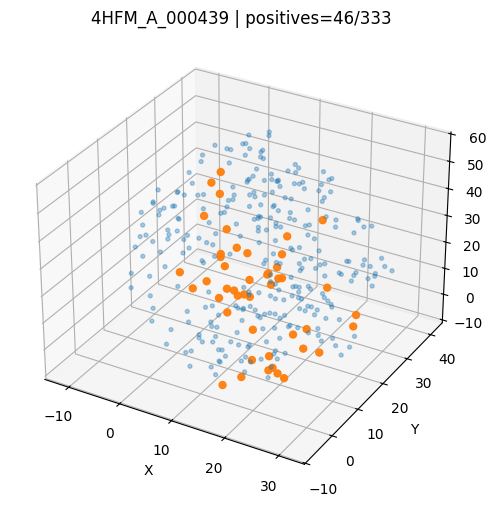

3WHK_A_000287 | ok coverage=1.000 missing=0


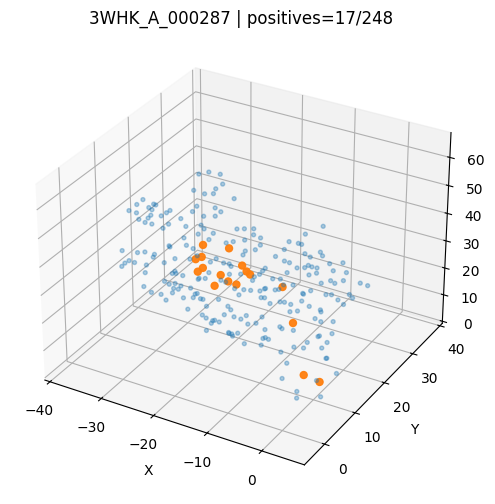

1I1A_C_000270 | ok coverage=1.000 missing=0


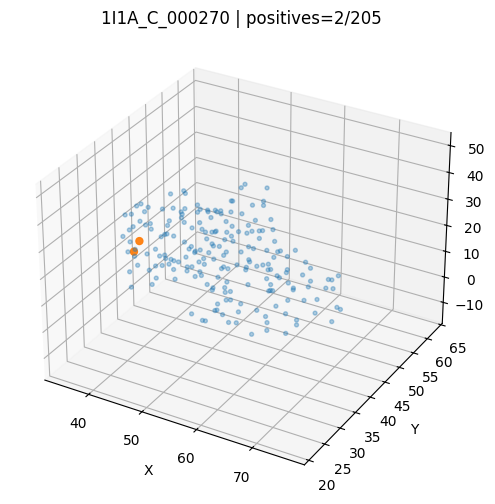

In [8]:
# Plot 3D scatter for a few graphs (labels highlighted)

import matplotlib.pyplot as plt

def plot_graph_3d(npz_path: Path):
    coords, y, resseq_kept, note = coords_for_graph(npz_path)
    print(npz_path.stem, "|", note)
    if coords is None:
        return

    neg = coords[y==0]
    pos = coords[y==1]

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")

    if len(neg) > 0:
        ax.scatter(neg[:,0], neg[:,1], neg[:,2], s=8, alpha=0.35)
    if len(pos) > 0:
        ax.scatter(pos[:,0], pos[:,1], pos[:,2], s=25, alpha=0.95)

    ax.set_title(f"{npz_path.stem} | positives={int(y.sum())}/{len(y)}")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.show()

# First: compute quick stats for the 10 sampled graphs
rows = []
for p in sample_files:
    z = np.load(p, allow_pickle=True)
    y = z["y"].astype(int)
    rows.append({"graph": p.stem, "positives": int(y.sum()), "n_nodes": int(z["n_nodes"])})
stats10 = pd.DataFrame(rows).sort_values("positives", ascending=False)
display(stats10)

# Plot: highest positives, median, lowest positives
stems = [stats10.iloc[0]["graph"], stats10.iloc[len(stats10)//2]["graph"], stats10.iloc[-1]["graph"]]
for stem in stems:
    plot_graph_3d(GDIR / f"{stem}.npz")


In [9]:
PLOT_DIR = OUT / "day11_label_plots"
PLOT_DIR.mkdir(exist_ok=True)

def save_graph_plot(npz_path: Path):
    coords, y, _, note = coords_for_graph(npz_path)
    if coords is None:
        print("Skip", npz_path.stem, note)
        return
    neg = coords[y==0]; pos = coords[y==1]

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")
    if len(neg) > 0:
        ax.scatter(neg[:,0], neg[:,1], neg[:,2], s=8, alpha=0.35)
    if len(pos) > 0:
        ax.scatter(pos[:,0], pos[:,1], pos[:,2], s=25, alpha=0.95)

    ax.set_title(f"{npz_path.stem} | {note} | pos={int(y.sum())}/{len(y)}")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

    outpath = PLOT_DIR / f"{npz_path.stem}.png"
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", outpath)

# Save the same 3 plotted graphs
for stem in stems:
    save_graph_plot(GDIR / f"{stem}.npz")


Saved: /content/drive/MyDrive/biolip_gnn/out/day11_label_plots/4HFM_A_000439.png
Saved: /content/drive/MyDrive/biolip_gnn/out/day11_label_plots/3WHK_A_000287.png
Saved: /content/drive/MyDrive/biolip_gnn/out/day11_label_plots/1I1A_C_000270.png


In [10]:
# 1I1A_C_000270 | ok coverage=1.000 missing=0

import re

def binding_numbers_from_raw_line_field7(raw_line: str):
    """
    BioLiP raw_line (tab-separated) often:
    0 pdb, 1 chain, 2 reso, 3 BSxx, 4 ligand, 5 ligand_chain, 6 ligand_serial,
    7 binding residues (THIS), then other residue lists...
    """
    if not isinstance(raw_line, str) or raw_line.strip() == "":
        return set(), "no_rawline"

    parts = raw_line.split("\t")
    if len(parts) <= 7:
        return set(), f"too_short_len={len(parts)}"

    field = parts[7].strip()
    if field == "":
        return set(), "empty_field7"

    toks = re.findall(r"[A-Z][0-9]+", field)
    nums = set()
    for t in toks:
        try:
            nums.add(int(t[1:]))
        except:
            pass
    return nums, "field7"



In [11]:
# Recompute labels for a graph (without rebuilding anything)

import numpy as np

def relabel_graph_using_field7(npz_path):
    z = np.load(npz_path, allow_pickle=True)
    resseq = z["resseq"].astype(int)
    raw_line = str(z.get("raw_line", ""))  # may not exist in npz; handle below

    # Your npz doesn't currently store raw_line, so we need to fetch it from the CSV:
    return resseq


In [12]:
# Load subset_500.csv and build a lookup for raw_line by (pdb_id, chain, row_idx)

from pathlib import Path
import pandas as pd

BASE = Path("/content/drive/MyDrive/biolip_gnn")
CSV = BASE / "out" / "subset_500.csv"
df500 = pd.read_csv(CSV)

# Build lookup: row_idx -> raw_line (because your graph filename includes row_idx)
# In your npz you saved row_idx explicitly.
rowidx_to_rawline = dict(zip(df500.index.astype(int), df500["raw_line"].astype(str)))

print("Lookup size:", len(rowidx_to_rawline))
print("Example raw_line:", rowidx_to_rawline.get(0, "")[:120])


Lookup size: 837
Example raw_line: 4b79	A	1.98	BS01	NAD	A	1	G17 S19 S20 G21 I22 L42 L60 D61 I62 N84 G86 L105 I131 Y146 K150 P176 G177 I179 T181	G17 S19 S20


4HFM_A_000439 | row_idx: 439 | label_mode: field7 | positives: 22 / 333


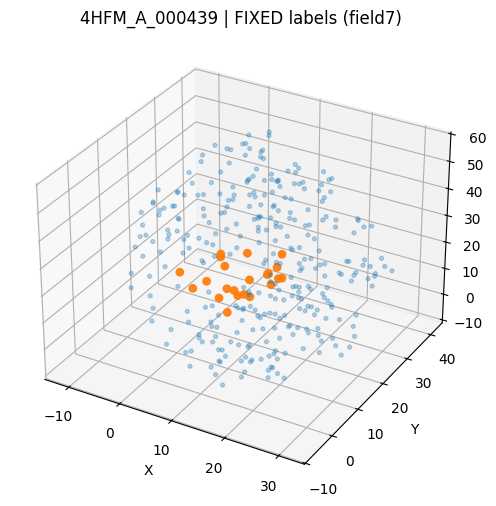

3WHK_A_000287 | row_idx: 287 | label_mode: field7 | positives: 12 / 248


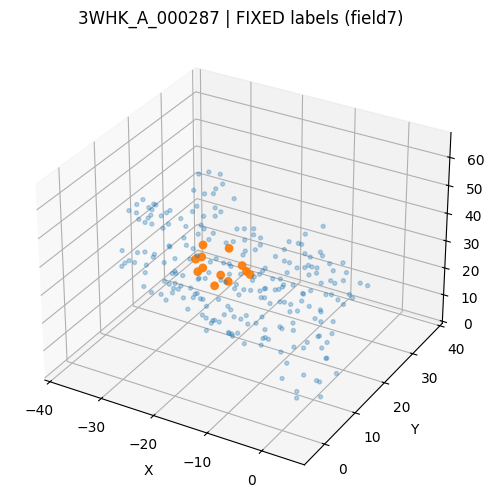

1I1A_C_000270 | row_idx: 270 | label_mode: field7 | positives: 2 / 205


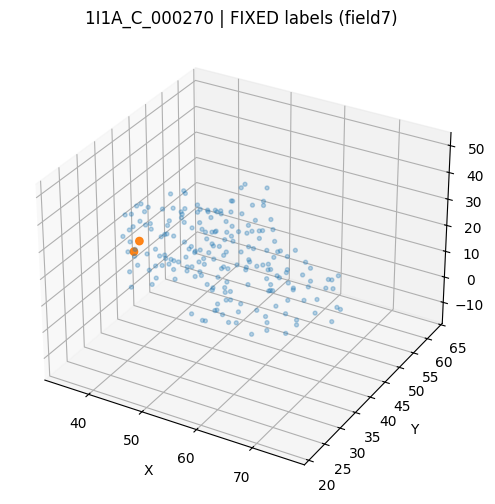

In [13]:
# Make “fixed labels” for one graph and re-plot (should look clustered if correct)

import matplotlib.pyplot as plt

def coords_for_graph(npz_path: Path):
    # uses your already-working functions from Day 11:
    # load_structure(), chain_ca_map() and mapping by resseq
    z = np.load(npz_path, allow_pickle=True)
    pdb_id = str(z["pdb_id"])
    chain  = str(z["chain"])
    resseq = z["resseq"].astype(int)

    structure, st = load_structure(pdb_id)
    if structure is None:
        return None, None, None, f"struct_{st}"

    cmap, st2 = chain_ca_map(structure, chain)
    if cmap is None:
        return None, None, None, f"chain_{st2}"

    coords = []
    kept_resseq = []
    for r in resseq:
        if int(r) in cmap:
            coords.append(cmap[int(r)])
            kept_resseq.append(int(r))
    if len(coords) == 0:
        return None, None, None, "no_coords_matched"

    return np.vstack(coords), np.array(kept_resseq, dtype=int), z, "ok"

def plot_fixed_labels(npz_path: Path):
    coords, kept_resseq, z, note = coords_for_graph(npz_path)
    if coords is None:
        print(npz_path.stem, note)
        return

    row_idx = int(z["row_idx"])
    raw_line = rowidx_to_rawline.get(row_idx, "")
    bind_nums, mode = binding_numbers_from_raw_line_field7(raw_line)

    # y_new aligned to kept_resseq order
    y_new = np.array([1 if int(r) in bind_nums else 0 for r in kept_resseq], dtype=int)

    neg = coords[y_new==0]
    pos = coords[y_new==1]

    print(npz_path.stem, "| row_idx:", row_idx, "| label_mode:", mode,
          "| positives:", int(y_new.sum()), "/", len(y_new))

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")
    if len(neg) > 0:
        ax.scatter(neg[:,0], neg[:,1], neg[:,2], s=8, alpha=0.30)
    if len(pos) > 0:
        ax.scatter(pos[:,0], pos[:,1], pos[:,2], s=28, alpha=0.95)
    ax.set_title(f"{npz_path.stem} | FIXED labels (field7)")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.show()

# Try the same 3 graphs you mentioned (or any you want)
for stem in ["4HFM_A_000439", "3WHK_A_000287", "1I1A_C_000270"]:
    plot_fixed_labels(GDIR / f"{stem}.npz")


In [14]:
# Batch relabel all graphs (fast, lightweight)

from pathlib import Path
import numpy as np
import pandas as pd
import re
from tqdm import tqdm

BASE = Path("/content/drive/MyDrive/biolip_gnn")
GDIR = BASE / "graphs_labeled_v4_500"
OUT_DIR = BASE / "out"
CSV = OUT_DIR / "subset_500.csv"

FIX_DIR = BASE / "graphs_labeled_v5_fixed837"
FIX_DIR.mkdir(exist_ok=True)

df500 = pd.read_csv(CSV)
rowidx_to_rawline = dict(zip(df500.index.astype(int), df500["raw_line"].astype(str)))

def binding_numbers_field(parts, field_idx):
    if len(parts) <= field_idx:
        return set()
    field = parts[field_idx].strip()
    if field == "":
        return set()
    toks = re.findall(r"[A-Z][0-9]+", field)
    nums = set()
    for t in toks:
        try:
            nums.add(int(t[1:]))
        except:
            pass
    return nums

def binding_nums_field7(raw_line):
    if not isinstance(raw_line, str) or raw_line.strip() == "":
        return set(), "no_rawline"
    parts = raw_line.split("\t")
    nums = binding_numbers_field(parts, 7)
    if len(nums) == 0:
        return set(), "empty_field7"
    return nums, "field7_fixed"

npz_files = sorted(GDIR.glob("*.npz"))
print("Graphs to relabel:", len(npz_files))

rows = []
for p in tqdm(npz_files):
    z = np.load(p, allow_pickle=True)

    row_idx = int(z["row_idx"])
    raw_line = rowidx_to_rawline.get(row_idx, "")
    bind_nums, mode = binding_nums_field7(raw_line)

    resseq = z["resseq"].astype(int)
    y_new = np.array([1 if int(r) in bind_nums else 0 for r in resseq], dtype=np.int64)

    # Save new npz (copy everything but replace y + label_mode)
    outpath = FIX_DIR / p.name
    np.savez_compressed(
        outpath,
        pdb_id=z["pdb_id"],
        chain=z["chain"],
        row_idx=row_idx,
        ligand_code=z["ligand_code"] if "ligand_code" in z.files else "",
        n_nodes=z["n_nodes"],
        resseq=resseq,
        x_idx=z["x_idx"],
        edge_index=z["edge_index"],
        edge_dist=z["edge_dist"],
        y=y_new,
        label_mode=mode
    )

    rows.append({
        "graph": p.stem,
        "row_idx": row_idx,
        "positives": int(y_new.sum()),
        "n_nodes": int(len(y_new)),
        "pos_rate": float(y_new.mean()),
        "label_mode": mode
    })

stats = pd.DataFrame(rows)
stats_path = OUT_DIR / "day11_relabel_stats_fixed837.csv"
stats.to_csv(stats_path, index=False)

print("Saved fixed graphs to:", FIX_DIR)
print("Count fixed graphs:", len(list(FIX_DIR.glob("*.npz"))))
print("Saved stats:", stats_path)
print(stats[["positives","pos_rate"]].describe())
print("\nLabel modes:", stats["label_mode"].value_counts().head(10))


Graphs to relabel: 837


100%|██████████| 837/837 [00:30<00:00, 27.01it/s]


Saved fixed graphs to: /content/drive/MyDrive/biolip_gnn/graphs_labeled_v5_fixed837
Count fixed graphs: 837
Saved stats: /content/drive/MyDrive/biolip_gnn/out/day11_relabel_stats_fixed837.csv
        positives    pos_rate
count  837.000000  837.000000
mean     8.540024    0.035681
std      7.151798    0.037855
min      0.000000    0.000000
25%      4.000000    0.014925
50%      7.000000    0.026316
75%     11.000000    0.043590
max     90.000000    0.465517

Label modes: label_mode
field7_fixed    836
empty_field7      1
Name: count, dtype: int64


In [15]:
# Quick sanity check (plot 1–2 fixed graphs)

import random
import numpy as np

fixed_files = sorted(FIX_DIR.glob("*.npz"))
print("Fixed graphs:", len(fixed_files))

for p in random.sample(fixed_files, 2):
    z = np.load(p, allow_pickle=True)
    print(p.stem, "| positives:", int(z["y"].sum()), "/", len(z["y"]), "| mode:", str(z["label_mode"]))


Fixed graphs: 837
8AXP_A_000527 | positives: 4 / 191 | mode: field7_fixed
8TLK_A_000411 | positives: 14 / 105 | mode: field7_fixed
